---

# **Identification of pigmented skin lesions - USING CNN**

---

*   Liliana Paola Castellanos Pinzón ( 2170095 )
*   Pedro Alfonso Jimenez Buenahora (2170082 )

---

In [30]:
pip install scikit-plot

In [31]:
#@title ## Imports libraries
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from numpy import save
import tensorflow as tf
import scikitplot as skplt
from tensorflow import keras
from sklearn.utils import resample
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from google.colab import drive
from PIL import Image
import matplotlib.image as mpimg
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

In [32]:
#@title ## Mount Drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/course-IA2/Skin-Cancer')

Mounted at /content/drive


In [ ]:
#@title  ## Import API Kaggle
!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
#@title  ## Import image dataset from Kaggle
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.19G/5.20G [00:56<00:00, 63.1MB/s]
100% 5.20G/5.20G [00:56<00:00, 98.5MB/s]


In [ ]:
#@title  ## Unzip the dataset
!unzip skin-cancer-mnist-ham10000

In [ ]:
#@title
!ls

In [ ]:
#@title  ## Read the Meta Data
csv = pd.read_csv('HAM10000_metadata.csv')
df = pd.DataFrame(csv)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


---

## Data Processing

---


In [ ]:
#@title  ## Define the path, the image extension and the diagnostic type
base = os.path.join('..', 'Skin-Cancer')
image_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base, '*', '*.jpg'))}
lesion_type = {'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'}
df = pd.read_csv(os.path.join(base, 'HAM10000_metadata.csv'))
#print(image_path)

In [ ]:
#@title  ## Added the path, the image extension and the diagnostic type
df['cell_type'] = df['dx'].map(lesion_type.get)
df['path'] = df['image_id'].map(image_path.get)
df['dx_code'] = pd.Categorical(df['dx']).codes
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,dx_code
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,../Skin-Cancer/ham10000_images_part_1/ISIC_002...,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,../Skin-Cancer/ham10000_images_part_1/ISIC_002...,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,../Skin-Cancer/ham10000_images_part_1/ISIC_002...,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,../Skin-Cancer/ham10000_images_part_1/ISIC_002...,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,../Skin-Cancer/ham10000_images_part_2/ISIC_003...,2


---
---

In [ ]:
#@title  ## Create a Backup of the Dataframe
df.to_csv('new_data.csv')

In [33]:
#@title  ## Read the Backup
csv2 = pd.read_csv('new_data.csv')
df2 = pd.DataFrame(csv2)
df2.head()

,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,dx_code,image
0,0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,../Skin-Cancer/ham10000_images_part_1/ISIC_002...,2,[[[190 153 194]\n [192 154 196]\n [191 153 1...
1,1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,../Skin-Cancer/ham10000_images_part_1/ISIC_002...,2,[[[23 13 22]\n [24 14 24]\n [25 14 28]\n .....
2,2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,../Skin-Cancer/ham10000_images_part_1/ISIC_002...,2,[[[185 127 137]\n [189 133 147]\n [194 136 1...
3,3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,../Skin-Cancer/ham10000_images_part_1/ISIC_002...,2,[[[24 11 17]\n [26 13 22]\n [38 21 32]\n .....
4,4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,../Skin-Cancer/ham10000_images_part_2/ISIC_003...,2,[[[134 90 113]\n [147 102 125]\n [159 115 1...


---
---

In [34]:
#@title  ## Define X and Y
#X = df2.drop(['dx_code'], axis = 1)
X = df2[['path']].values
Y = df2['dx_code']

In [ ]:
#@title  ## Reshape the images and save in an array
import cv2
from tensorflow import keras
from IPython.display import clear_output

X_images=[]
i=0
for img in X:
  ejemplo = np.array2string(img)[2:-2]
  ejemplo1 = cv2.imread(os.path.join('../Skin-Cancer',ejemplo))
  ejemplo1 = cv2.cvtColor(ejemplo1, cv2.COLOR_BGR2RGB)
  ejemplo2 = cv2.resize(ejemplo1,(200,150))
  X_images.append(ejemplo2)
  clear_output(wait=True)
  i=i+1
  print(i,"/",X.shape[0])
X_i = np.array(X_images)

#print(X_)

10015 / 10015


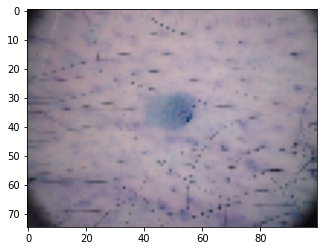

In [ ]:
#@title  ## Images Before COLOR_BGR 2 RGB 
index =  30
import matplotlib.image as mpimg
plt.imshow(X_i[index])

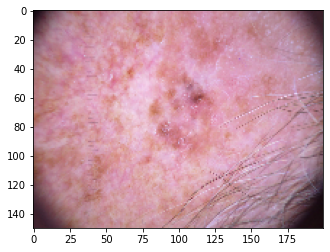

In [ ]:
#@title  ## Images After COLOR_BGR 2 RGB 
index =  3
import matplotlib.image as mpimg
plt.imshow(X_i[index])

---
---

In [ ]:
#@title  ## Create a Backup of the array
from numpy import save
save('X_i_2.npy', X_i)

In [35]:
#@title  ## Read the Backup of the array
X_i = np.load('X_i_2.npy')

#for img in X_2:
#  X_2[img] = cv2.cvtColor(X_2[img], cv2.COLOR_BGR2RGB)
#  clear_output(wait=True)
#  i=i+1
#  print(i,"/",X_2.shape[0])
print(X_i)

[[[[187 152 194]
   [190 155 197]
   [193 158 198]
   ...
   [196 152 165]
   [197 155 167]
   [195 159 169]]

  [[189 151 192]
   [192 154 195]
   [191 154 195]
   ...
   [191 153 164]
   [198 157 171]
   [195 155 163]]

  [[190 147 192]
   [191 148 194]
   [187 147 184]
   ...
   [194 153 169]
   [195 154 168]
   [191 159 162]]

  ...

  [[162 128 161]
   [165 132 163]
   [167 132 162]
   ...
   [184 149 173]
   [184 151 170]
   [179 147 162]]

  [[161 124 157]
   [164 125 156]
   [164 130 157]
   ...
   [188 156 180]
   [182 151 169]
   [178 146 157]]

  [[156 123 154]
   [160 120 154]
   [158 122 148]
   ...
   [186 157 187]
   [181 152 170]
   [175 144 159]]]


 [[[ 23  12  20]
   [ 24  12  22]
   [ 23  13  24]
   ...
   [ 60  37  65]
   [ 59  36  64]
   [ 61  38  64]]

  [[ 23  14  19]
   [ 20  13  20]
   [ 20  13  21]
   ...
   [ 60  38  61]
   [ 62  35  66]
   [ 61  36  65]]

  [[ 23  11  25]
   [ 24  12  22]
   [ 25  13  27]
   ...
   [ 63  39  65]
   [ 60  37  63]
   [ 58  34

---
### **Resize the images of 600x450 to 150x200 (1/3) doesn´t change a lot of info (in this case)**
---
## Look, when the images of this problemsheet are reshaped, the majority of the information still persist, and the perfomance also improves
---

im_01:  <class 'PIL.Image.Image'> (1, 450, 600, 3)


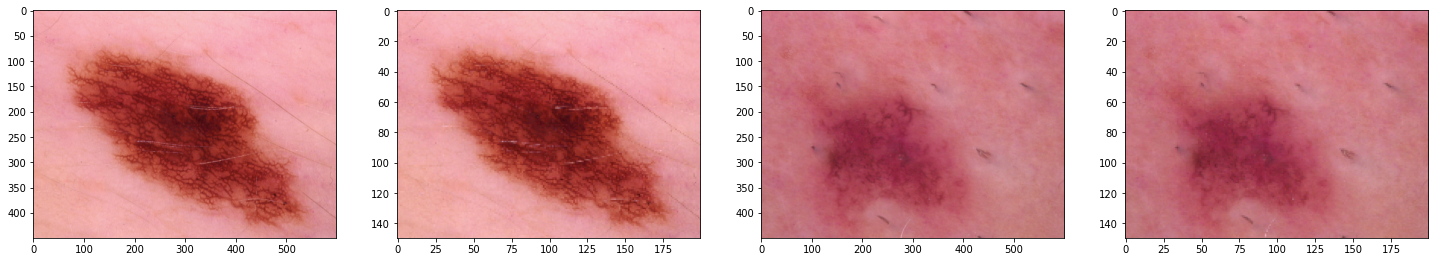

In [ ]:
im_01 = tf.keras.preprocessing.image.load_img("ham10000_images_part_1/ISIC_0024308.jpg", target_size=(450, 600)) # 600x400 pixels
im_02 = tf.keras.preprocessing.image.load_img("ham10000_images_part_1/ISIC_0024308.jpg", target_size=(150, 200)) # 100x75 pixel (Resized)
im_03 = tf.keras.preprocessing.image.load_img("ham10000_images_part_1/ISIC_0024309.jpg", target_size=(450, 600)) # 600x400 pixels
im_04 = tf.keras.preprocessing.image.load_img("ham10000_images_part_1/ISIC_0024309.jpg", target_size=(150, 200)) # 100x75 pixel (Resized)
ima_01 = np.expand_dims(tf.keras.preprocessing.image.img_to_array(im_01), axis=0);
ima_02 = np.expand_dims(tf.keras.preprocessing.image.img_to_array(im_02), axis=0);
ima_03 = np.expand_dims(tf.keras.preprocessing.image.img_to_array(im_03), axis=0);
ima_04 = np.expand_dims(tf.keras.preprocessing.image.img_to_array(im_04), axis=0);

print ( "im_01: ", type(im_02), ima_01.shape )

fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1, 4, 1)
ax = plt.imshow(im_01);
ax = fig.add_subplot(1, 4, 2)
ax = plt.imshow(im_02);
ax = fig.add_subplot(1, 4, 3)
ax = plt.imshow(im_03);
ax = fig.add_subplot(1, 4, 4)
ax = plt.imshow(im_04);

---

In [37]:
#@title  ## Define the Training Data
x_train, x_test, y_train, y_test = train_test_split(X_i, Y, test_size = 0.2)

In [38]:
y_train = tf.keras.utils.to_categorical(y_train, 7)
y_test = tf.keras.utils.to_categorical(y_test, 7)

In [ ]:
#@title  ## Define the Model
model_noob =  tf.keras.applications.MobileNetV2(input_shape=(150,200,3), weights='imagenet', include_top=False)
model_noob.trainable = False
model_noob.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 100, 32)  864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 100, 32)  128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 100, 32)  0           ['bn_Conv1[0][

In [ ]:
#@title   ## Show the len of the imported model
len(model_noob.layers)

154

In [ ]:
#@title  ## Define some layers for train
model_noob.trainable = True
#agregado
set_trainable = False
#fin agregado
#print("Total ayers of model_pro: ", len(model_noob.layers))
#for layer in model_noob.layers[:120]:
#  layer.trainable =  False

for layer in model_noob.layers:
  if layer.name == 'expanded_conv_project':
    set_trainable = True
  if set_trainable: 
    layer.trainable = True
  else:
    layer.trainable = False

model_noob.summary()
len(model_noob.trainable_variables)

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 100, 32)  864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 100, 32)  128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 100, 32)  0           ['bn_Conv1[0][

150

In [ ]:
#@title  ## Some layers added
model_pro = tf.keras.Sequential([
  model_noob,
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(256, activation="relu"),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(7, activation="softmax")
])
model_pro.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout_4 (Dropout)         (None, 5, 7, 1280)        0         
                                                                 
 batch_normalization_4 (Batc  (None, 5, 7, 1280)       5120      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 5, 7, 256)         327936    
                                                                 
 global_average_pooling2d_3   (None, 256)              0         
 (GlobalAveragePooling2D)                                        
                                                      

Epoch 1/200
63/63 [==============================] - 58s 834ms/step - loss: 2.4770 - accuracy: 0.1952 - val_loss: 2.3318 - val_accuracy: 0.0429
Epoch 2/200
63/63 [==============================] - 51s 811ms/step - loss: 2.2768 - accuracy: 0.2406 - val_loss: 2.3824 - val_accuracy: 0.0434
Epoch 3/200
63/63 [==============================] - 51s 812ms/step - loss: 2.1098 - accuracy: 0.2966 - val_loss: 2.3305 - val_accuracy: 0.0479
Epoch 4/200
63/63 [==============================] - 51s 815ms/step - loss: 1.9866 - accuracy: 0.3374 - val_loss: 2.3129 - val_accuracy: 0.0484
Epoch 5/200
63/63 [==============================] - 51s 811ms/step - loss: 1.8780 - accuracy: 0.3651 - val_loss: 2.2533 - val_accuracy: 0.0599
Epoch 6/200
63/63 [==============================] - 51s 811ms/step - loss: 1.7861 - accuracy: 0.4071 - val_loss: 2.1731 - val_accuracy: 0.0724
Epoch 7/200
63/63 [==============================] - 51s 811ms/step - loss: 1.7001 - accuracy: 0.4361 - val_loss: 2.1457 - val_accuracy:

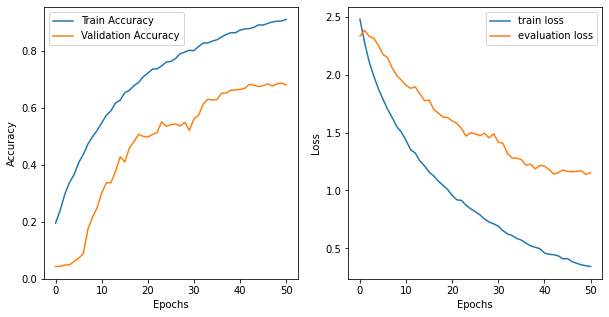

In [ ]:
#@title  ## Training the model
learning_rate= 0.0005
opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
model_pro.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta = 0.01, patience = 8, restore_best_weights = True)
history = model_pro.fit(x_train, y_train, epochs=200, verbose=1, validation_data=(x_test,y_test), batch_size=128, callbacks=callback)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

---
---

In [ ]:
#@title  ## Create a backup of the model
model_pro.save("model_NOOB_Backup.h5")

In [39]:
#@title  ## Read the backup of the model
model_pro = models.load_model("model_NOOB_Backup.h5")

---
---

In [70]:
#@title  ## Some functions to plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class_names = ['Melanocytic nevi', 'Melanoma', 'Benign keratosis-like lesions ', 'Basal cell carcinoma', 'Actinic keratoses', 'Vascular lesions', 'Dermatofibroma']


def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape(150, 200, 3), cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

---

valor predicho: 5  clase:  Vascular lesions
max prob:  0.5527922 ground truth:  Vascular lesions
394
(2003, 7)


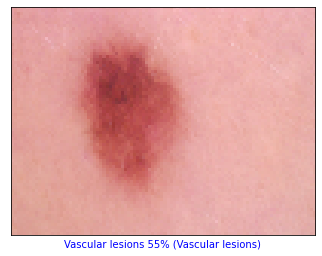

In [ ]:
#@title  ## Plot Results
import random
index_vector =  random.randint(0,len(x_test))

predictions = model_pro.predict(x_test)
print ("valor predicho:",  np.argmax(predictions[index_vector]), " clase: ", class_names[np.argmax(predictions[index_vector])])
print ("max prob: ", np.max(predictions[index_vector]), "ground truth: ", class_names[np.argmax(y_test ,axis=1)[index_vector]])

print(index_vector)
print(predictions.shape)
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plot_image(index_vector, predictions, np.argmax(y_test ,axis=1), x_test)
#plt.subplot(1,2,2)
#plot_value_array(index_vector, predictions,  np.argmax(y_test ,axis=1))

valor predicho: 5  clase:  Vascular lesions
max prob:  0.8491037 ground truth:  Vascular lesions
342
(2003, 7)


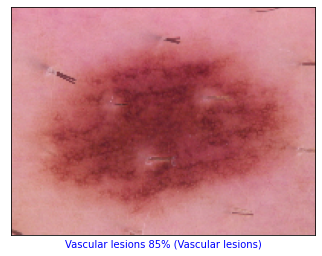

In [71]:
#@title  ## Plot Results
import random
index_vector =  random.randint(0,len(x_test))

predictions = model_pro.predict(x_test)
print ("valor predicho:",  np.argmax(predictions[index_vector]), " clase: ", class_names[np.argmax(predictions[index_vector])])
print ("max prob: ", np.max(predictions[index_vector]), "ground truth: ", class_names[np.argmax(y_test ,axis=1)[index_vector]])

print(index_vector)
print(predictions.shape)
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plot_image(index_vector, predictions, np.argmax(y_test ,axis=1), x_test)
#plt.subplot(1,2,2)
#plot_value_array(index_vector, predictions,  np.argmax(y_test ,axis=1))

valor predicho: 1  clase:  Melanoma
max prob:  0.2466865 ground truth:  Melanoma
1706
(2003, 7)


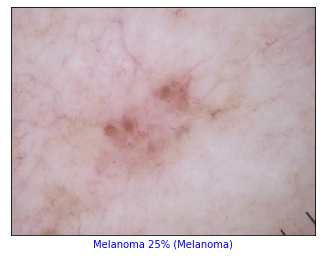

In [72]:
#@title  ## Plot Results
import random
index_vector =  random.randint(0,len(x_test))

predictions = model_pro.predict(x_test)
print ("valor predicho:",  np.argmax(predictions[index_vector]), " clase: ", class_names[np.argmax(predictions[index_vector])])
print ("max prob: ", np.max(predictions[index_vector]), "ground truth: ", class_names[np.argmax(y_test ,axis=1)[index_vector]])

print(index_vector)
print(predictions.shape)
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plot_image(index_vector, predictions, np.argmax(y_test ,axis=1), x_test)
#plt.subplot(1,2,2)
#plot_value_array(index_vector, predictions,  np.argmax(y_test ,axis=1))

valor predicho: 4  clase:  Actinic keratoses
max prob:  0.8269507 ground truth:  Actinic keratoses
288
(2003, 7)


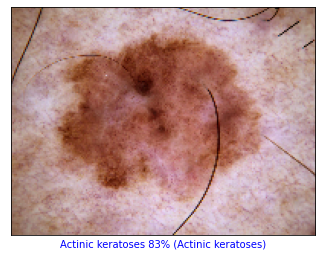

In [73]:
#@title  ## Plot Results
import random
index_vector =  random.randint(0,len(x_test))

predictions = model_pro.predict(x_test)
print ("valor predicho:",  np.argmax(predictions[index_vector]), " clase: ", class_names[np.argmax(predictions[index_vector])])
print ("max prob: ", np.max(predictions[index_vector]), "ground truth: ", class_names[np.argmax(y_test ,axis=1)[index_vector]])

print(index_vector)
print(predictions.shape)
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plot_image(index_vector, predictions, np.argmax(y_test ,axis=1), x_test)
#plt.subplot(1,2,2)
#plot_value_array(index_vector, predictions,  np.argmax(y_test ,axis=1))

valor predicho: 5  clase:  Vascular lesions
max prob:  0.5136396 ground truth:  Melanoma
514
(2003, 7)


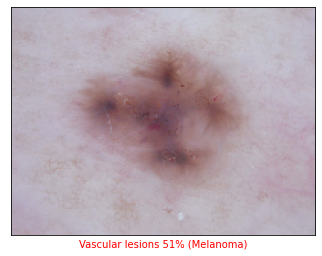

In [76]:
#@title  ## Plot Results
import random
index_vector =  random.randint(0,len(x_test))

predictions = model_pro.predict(x_test)
print ("valor predicho:",  np.argmax(predictions[index_vector]), " clase: ", class_names[np.argmax(predictions[index_vector])])
print ("max prob: ", np.max(predictions[index_vector]), "ground truth: ", class_names[np.argmax(y_test ,axis=1)[index_vector]])

print(index_vector)
print(predictions.shape)
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plot_image(index_vector, predictions, np.argmax(y_test ,axis=1), x_test)
#plt.subplot(1,2,2)
#plot_value_array(index_vector, predictions,  np.argmax(y_test ,axis=1))

valor predicho: 2  clase:  Benign keratosis-like lesions 
max prob:  0.35054755 ground truth:  Melanocytic nevi
1682
(2003, 7)


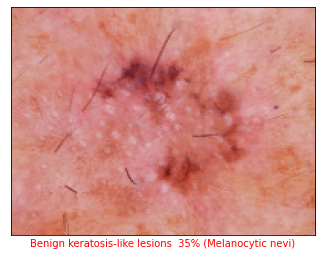

In [78]:
#@title  ## Plot Results
import random
index_vector =  random.randint(0,len(x_test))

predictions = model_pro.predict(x_test)
print ("valor predicho:",  np.argmax(predictions[index_vector]), " clase: ", class_names[np.argmax(predictions[index_vector])])
print ("max prob: ", np.max(predictions[index_vector]), "ground truth: ", class_names[np.argmax(y_test ,axis=1)[index_vector]])

print(index_vector)
print(predictions.shape)
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plot_image(index_vector, predictions, np.argmax(y_test ,axis=1), x_test)
#plt.subplot(1,2,2)
#plot_value_array(index_vector, predictions,  np.argmax(y_test ,axis=1))

valor predicho: 4  clase:  Actinic keratoses
max prob:  0.49484265 ground truth:  Melanoma
828
(2003, 7)


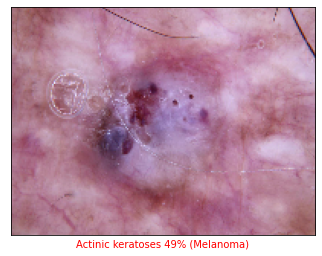

In [86]:
#@title  ## Plot Results
import random
index_vector =  random.randint(0,len(x_test))

predictions = model_pro.predict(x_test)
print ("valor predicho:",  np.argmax(predictions[index_vector]), " clase: ", class_names[np.argmax(predictions[index_vector])])
print ("max prob: ", np.max(predictions[index_vector]), "ground truth: ", class_names[np.argmax(y_test ,axis=1)[index_vector]])

print(index_vector)
print(predictions.shape)
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plot_image(index_vector, predictions, np.argmax(y_test ,axis=1), x_test)
#plt.subplot(1,2,2)
#plot_value_array(index_vector, predictions,  np.argmax(y_test ,axis=1))